# 批量归一化
## （1）从零实现

In [3]:
# 解决内核挂掉的问题
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    """
    X:输入数据
    gamma:批量归一化中，可学习的参数
    beta:批量归一化中，可学习的参数
    moving_mean:全局的均值
    moving_mean:全局的方差
    eps:避免分母为零而加
    momentum:用来更新moving_mean，moving_mean，通常取0.9
    """
    if not torch.is_grad_enabled(): # 推理时用的（不算梯度）
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps) # 推理时用，用全局均值和方差，是因为可能此时还没有批量的均值和方差
    else: # 训练时用
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True) # 在通道、高、宽维度做均值
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        
        # 下面这两个是在无限的逼近全局的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data # 返回的值Y其实就是给X做了一个线性变换

创建一个正确的 BatchNorm 图层

In [4]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims): # 特征数量和输入数据的维度
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1) # 通道数、特征数、高、宽
        # 下面这两个是可训练的参数
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 不需要训练的参数
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device: # 因为没有放入nn.Parameter，因此需要手动放入gpu
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

应用BatchNorm 于LeNet模型

In [5]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

在Fashion-MNIST数据集上训练网络

loss 0.241, train acc 0.912, test acc 0.837
30415.6 examples/sec on cuda:0


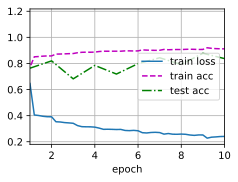

In [6]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数 gamma 和偏移参数 beta

In [8]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.3005, 1.6953, 1.9102, 2.4272, 1.1982, 1.7352], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-2.2702, -0.0891,  1.2049, -0.1961, -0.6144, -0.3574], device='cuda:0',
        grad_fn=<ViewBackward>))

## （2）简洁实现（调包实现）

In [10]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), # 注意pytorch在批量归一化层，只需要给出特征数，不需要输入数据的形状，会自动帮我们推导
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.253, train acc 0.908, test acc 0.783
69096.1 examples/sec on cuda:0


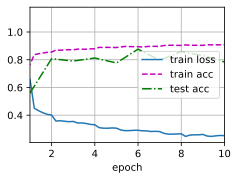

In [11]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())